In [1]:
# ===================================================================
# Cellule 1 : Import des bibliothèques et configuration initiale
# ===================================================================
import os
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from io import StringIO
import json
from datetime import datetime

# Import de PyTorch Geometric
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv, VGAE
    from torch_geometric.utils import train_test_split_edges, negative_sampling
    import torch.nn.functional as F
except ImportError:
    print("ERREUR: PyTorch Geometric n'est pas installé.")
    print("Veuillez l'installer, par exemple avec : pip install torch-geometric")
    # Pour Colab, des commandes plus spécifiques peuvent être nécessaires.
    exit()

# Configuration de l'affichage et des visualisations
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

# Définition de l'appareil (GPU si disponible, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cpu


In [2]:
# ===================================================================
# Cellule 2 : Chargement et préparation des nouvelles données (v3)
# ===================================================================
# MODIFICATION : Noms des fichiers de la version 3 avec géo-features
graph_path = 'construction/credential_stuffing_graph_v3.pt'
mapping_path = 'construction/node_mapping_v3.pt'

if not os.path.exists(graph_path) or not os.path.exists(mapping_path):
    raise FileNotFoundError(
        "Fichiers de graphe V3 non trouvés. "
        "Assurez-vous d'avoir exécuté 'construction_graphe.ipynb' avec les modifications pour les caractéristiques géographiques."
    )

# Charger les objets PyG et le mapping
data = torch.load(graph_path, weights_only=False)
idx_to_node = torch.load(mapping_path, weights_only=False)
node_to_idx = {v: k for k, v in idx_to_node.items()}

print("--- Graphe V3 chargé (avec géo-features) ---")
print(data)
print(f"Nombre de caractéristiques par nœud : {data.num_node_features}") # Devrait afficher 8

# --- Normalisation des caractéristiques des nœuds (Z-score) ---
x_mean = data.x.mean(dim=0, keepdim=True)
x_std = data.x.std(dim=0, keepdim=True) + 1e-8
data.x = (data.x - x_mean) / x_std
print("\nCaractéristiques des nœuds normalisées.")

# Déplacer les données vers le bon appareil
data = data.to(device)
print(f"Données déplacées vers '{device}'.")

# --- Reconstruction d'un DataFrame de caractéristiques pour l'analyse ---
# MODIFICATION : Ajout des nouvelles colonnes de caractéristiques
feature_names = [
    'is_ip', 'is_user', 'degree', 'total_attempts', 
    'failure_rate', 'specific_feature', 
    'num_countries', 'num_cities'  # Nouvelles caractéristiques
]
node_features_df = pd.DataFrame(data.x.cpu().numpy(), columns=feature_names)
node_features_df['node_id'] = node_features_df.index.map(idx_to_node.get)
node_features_df = node_features_df.set_index('node_id')

print("\nAperçu du DataFrame des caractéristiques (avec géo-features) :")
display(node_features_df.head())

--- Graphe V3 chargé (avec géo-features) ---
Data(x=[14671, 8], edge_index=[2, 32774], edge_attr=[32774, 3])
Nombre de caractéristiques par nœud : 8

Caractéristiques des nœuds normalisées.
Données déplacées vers 'cpu'.

Aperçu du DataFrame des caractéristiques (avec géo-features) :


,is_ip,is_user,degree,total_attempts,failure_rate,specific_feature,num_countries,num_cities
node_id,,,,,,,,
674a135355e8b1e1e55b932e176415c3c85290676ff72ce8a7d14db986becc84,2.601169,-2.601169,-0.027199,-0.017220,-0.206321,-0.027199,-0.183497,-0.066322
cfd5065ab4d87895601e26bd782055667e7b9d033424b6707a5d3f68cbc82791,2.601169,-2.601169,56.687469,58.237980,-0.206321,56.687469,-0.183497,-0.066322
fe14787607e69d705c79db451fa77bbe721ac9f1c55b6fc88b7427bf3b32a792,2.601169,-2.601169,29.575521,24.531134,-0.206321,29.575521,-0.183497,-0.066322
95b951dd7f08f826d2d37ae08e55d3ae1495a34296b14ef80af0a0a70b6e0faa,2.601169,-2.601169,-0.027199,0.018696,-0.206321,-0.027199,-0.183497,-0.066322
87d85321a85e642c79f0959209819f3b67002c2eda400ac6d8eee2d58f0581d1,2.601169,-2.601169,55.497189,57.393959,-0.206321,55.497189,-0.183497,-0.066322


In [3]:
# ===================================================================
# Cellule 3 : Définition des classes de modèles (VGAE) 
# ===================================================================

# --- 1. Encodeur de base ---
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv_mu = GCNConv(hidden_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    

# --- 2. Encodeur amélioré ---
class ImprovedVariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels, eps=1e-4)) # MODIFIED: Increased eps
        
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels, eps=1e-4)) # MODIFIED: Increased eps
        
        self.conv_mu = GCNConv(hidden_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
# --- 3. Classe VGAE modifiée pour intégrer le facteur beta ---
class CustomVGAE(torch.nn.Module):
    def __init__(self, encoder, beta=1.0):
        super().__init__()
        self.encoder = encoder
        self.beta = beta

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        return mu

    def decode(self, z, edge_index):
        row, col = edge_index
        dot_product = torch.sum(z[row] * z[col], dim=1)
        return torch.sigmoid(dot_product)
        
    # ====================================================================
    # CORRECTION : Ajout de la méthode decode_all manquante.
    # Cette méthode reconstruit la matrice d'adjacence complète.
    def decode_all(self, z):
        """
        Décodeur complet qui calcule la matrice d'adjacence reconstruite.
        """
        # Le produit scalaire de tous les embeddings (z) avec tous les autres (z.t())
        # donne la matrice complète des similarités.
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj)
    # ====================================================================

    def kl_loss(self, mu, logstd):
        kl = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - (2 * logstd).exp(), dim=1))
        return self.beta * kl

print("Classes des modèles définies (avec méthode decode_all ajoutée).")

Classes des modèles définies (avec méthode decode_all ajoutée).


In [4]:
# ===================================================================
# CELLULE 4 : Fonction d'entraînement et d'évaluation du modèle
# ===================================================================
def train_model(model, train_data, epochs, lr=0.01, weight_decay=1e-5):
    """Fonction générique pour entraîner notre CustomVGAE."""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    losses = []
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        
        mu, logstd = model.encoder(train_data.x, train_data.train_pos_edge_index)
        z = model.reparametrize(mu, logstd)
        
        pos_edge_index = train_data.train_pos_edge_index
        pos_pred = model.decode(z, pos_edge_index)
        recon_loss = -torch.log(pos_pred + 1e-15).mean()
        
        kl_loss = (1 / train_data.num_nodes) * model.kl_loss(mu, logstd)
        
        loss = recon_loss + kl_loss
                
        loss.backward()
        
        # ====================================================================
        # CORRECTION DE STABILITÉ : Ajout du rognage de gradient
        # Cela empêche les gradients d'exploser, cause fréquente de NaN.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # ====================================================================

        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
    return model, losses

# NOTE : La fonction d'évaluation doit aussi être adaptée
def evaluate_model(model, data):
    """Évalue un modèle sur les ensembles de validation et de test."""
    model.eval()
    with torch.no_grad():
        mu, logstd = model.encoder(data.x, data.train_pos_edge_index)
        z = model.reparametrize(mu, logstd)
        
        # Validation
        pos_pred_val = model.decode(z, data.val_pos_edge_index)
        neg_pred_val = model.decode(z, data.val_neg_edge_index)
        y_pred_val = torch.cat([pos_pred_val, neg_pred_val]).cpu()
        y_true_val = torch.cat([torch.ones_like(pos_pred_val), torch.zeros_like(neg_pred_val)]).cpu()
        
        # Vérification pour un débogage facile
        if torch.isnan(y_pred_val).any():
            raise ValueError("Erreur critique : NaN détecté dans les prédictions de validation !")

        val_auc = roc_auc_score(y_true_val, y_pred_val)
        val_ap = average_precision_score(y_true_val, y_pred_val)

        # Test
        pos_pred_test = model.decode(z, data.test_pos_edge_index)
        neg_pred_test = model.decode(z, data.test_neg_edge_index)
        y_pred_test = torch.cat([pos_pred_test, neg_pred_test]).cpu()
        y_true_test = torch.cat([torch.ones_like(pos_pred_test), torch.zeros_like(neg_pred_test)]).cpu()
        
        if torch.isnan(y_pred_test).any():
            raise ValueError("Erreur critique : NaN détecté dans les prédictions de test !")
            
        test_auc = roc_auc_score(y_true_test, y_pred_test)
        test_ap = average_precision_score(y_true_test, y_pred_test)
    
    return val_auc, val_ap, test_auc, test_ap

print("Fonctions d'entraînement (avec clipping) et d'évaluation prêtes.")

Fonctions d'entraînement (avec clipping) et d'évaluation prêtes.


/opt/homebrew/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Données divisées pour l'entraînement/validation/test :
 Data(x=[14671, 8], val_pos_edge_index=[2, 819], val_pos_edge_attr=[819, 3], test_pos_edge_index=[2, 1638], test_pos_edge_attr=[1638, 3], train_pos_edge_index=[2, 27860], train_pos_edge_attr=[27860, 3], train_neg_adj_mask=[14671, 14671], val_neg_edge_index=[2, 819], test_neg_edge_index=[2, 1638])

--- Entraînement du Modèle Original ---
Epoch: 001, Loss: 36513.8320
Epoch: 020, Loss: 0.0027
Epoch: 020, Loss: 0.0027
Epoch: 040, Loss: 0.0046
Epoch: 040, Loss: 0.0046
Epoch: 060, Loss: 0.0043
Epoch: 060, Loss: 0.0043
Epoch: 080, Loss: 0.0037
Epoch: 080, Loss: 0.0037
Epoch: 100, Loss: 0.0032
Epoch: 100, Loss: 0.0032
Epoch: 120, Loss: 0.0028
Epoch: 120, Loss: 0.0028
Epoch: 140, Loss: 0.0025
Epoch: 140, Loss: 0.0025
Epoch: 160, Loss: 0.0022
Epoch: 160, Loss: 0.0022
Epoch: 180, Loss: 0.0020
Epoch: 180, Loss: 0.0020
Epoch: 200, Loss: 0.0018

--- Entraînement du Modèle Amélioré ---
Epoch: 001, Loss: 1213400163858820271964160.0000
Epoch: 200, 

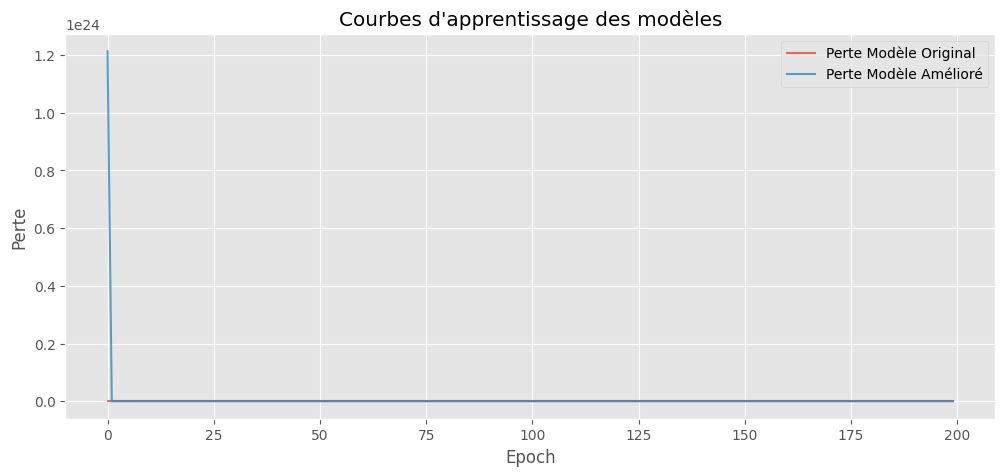

In [5]:
# ===================================================================
# Cellule 5 : Instanciation, Entraînement et Évaluation 
# ===================================================================

# =================================================================================
# CORRECTION : On sauvegarde le edge_index original AVANT de le perdre.
# La fonction train_test_split_edges supprime l'attribut data.edge_index.
# On utilise .clone() pour s'assurer d'avoir une copie indépendante.
# =================================================================================
original_edge_index = data.edge_index.clone()

# --- 1. Diviser les données ---
# Cette opération est stochastique et supprime data.edge_index.
data_split = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)
data_split = data_split.to(device)
print("Données divisées pour l'entraînement/validation/test :\n", data_split)
# À ce stade, data.edge_index est None, mais nous avons notre sauvegarde !

# --- 2. Définir les hyperparamètres ---
IN_CHANNELS = data.num_node_features
HIDDEN_CHANNELS = 64
LATENT_DIM = 32
EPOCHS = 200
LEARNING_RATE = 0.01

# --- 3. Modèle Original ---
print("\n--- Entraînement du Modèle Original ---")
encoder_orig = VariationalGCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM)
model_orig = CustomVGAE(encoder_orig, beta=1.0).to(device)
model_orig, losses_orig = train_model(model_orig, data_split, epochs=EPOCHS, lr=LEARNING_RATE)

# --- 4. Modèle Amélioré ---
print("\n--- Entraînement du Modèle Amélioré ---")
encoder_imp = ImprovedVariationalGCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS * 2, LATENT_DIM * 2)
model_improved = CustomVGAE(encoder_imp, beta=0.5).to(device)
model_improved, losses_imp = train_model(model_improved, data_split, epochs=EPOCHS, lr=LEARNING_RATE)

# --- 5. Évaluation comparative ---
print("\n--- Évaluation finale ---")
val_auc_orig, val_ap_orig, test_auc_orig, test_ap_orig = evaluate_model(model_orig, data_split)
val_auc_imp, val_ap_imp, test_auc_imp, test_ap_imp = evaluate_model(model_improved, data_split)

results_df = pd.DataFrame({
    'Modèle': ['Original', 'Amélioré'],
    'Test AUC': [test_auc_orig, test_auc_imp],
    'Test AP': [test_ap_orig, test_ap_imp],
    'Val AUC': [val_auc_orig, val_auc_imp],
    'Val AP': [val_ap_orig, val_ap_imp]
})
print("\n--- RÉSULTATS COMPARATIFS ---")
print(results_df.round(4))

# --- 6. Visualisation des pertes ---
plt.figure(figsize=(12, 5))
plt.plot(losses_orig, label='Perte Modèle Original', alpha=0.8)
plt.plot(losses_imp, label='Perte Modèle Amélioré', alpha=0.8)
plt.title("Courbes d'apprentissage des modèles")
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.legend()
plt.grid(True)
plt.show()


--- Top 10 IPs suspectes (Modèle Original) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,score_orig,score_imp
node_id,,,,,,,
d5a0e6b906c0a607a95937ff7a125582e0ac106a0268b76650354a9966e02ebf,2.100921,-0.005156,0.054612,-0.183497,-0.066322,0.000138,0.0
5bc4fbbfab56ad73130a4f62b8ae567daab264dd5dded17df633a7a959f06aba,0.947300,0.016886,0.054612,-0.183497,-0.066322,0.000126,0.0
7af4614458cd491e6857dfb2c78cee77241da45fc14f4b844dab3a7c0981f3ec,0.562760,-0.005156,0.108485,-0.183497,-0.066322,0.000103,0.0
6690ea7e625acd2f3a6e985e2717c1cc4703ef3619577a6f9983b17236f6c88f,-0.206321,0.016886,0.054612,-0.183497,-0.066322,0.000068,0.0
18a53a14a6694c646e52f65acb6621812e034d733f4a2dda3ed0ca38e8a1b1fb,-0.206321,-0.005156,0.018696,-0.183497,-0.066322,0.000038,0.0
acd0c1114b739d8ee01c393333fb0f98fb5d6210458fc149b8953649b0f04126,-0.206321,0.083013,0.359895,-0.183497,-0.066322,0.000031,0.0
5b445de2c53759a3ed333a008054f558dd2625f66c8f103fe7eaf4d7fd82edba,-0.206321,-0.005156,0.162359,-0.183497,-0.066322,0.000025,0.0
1073dbd25fc935e38f622e7fc63c4b5a2417d495f08fb12f2859b78dbf603575,-0.206321,-0.005156,0.108485,-0.183497,-0.066322,0.000022,0.0
ba3e5f02e7dc2674dc2220183af977ced937f6c434a351f72523f037a67d6397,-0.206321,-0.005156,0.018696,-0.183497,-0.066322,0.000018,0.0



--- Top 10 IPs suspectes (Modèle Amélioré) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,score_orig,score_imp
node_id,,,,,,,
e1d6e1fc34d7d66f55f134f2780dc8b188604c8465e4ef9f70cf920ced5533bc,-0.206321,-0.027199,0.036654,-0.183497,-0.066322,0.0,1.0
58629c8240b9fd1dd60cf357da10f0fb27d0894df605fca6900011a483b05431,-0.206321,-0.027199,-0.017220,-0.183497,-0.066322,0.0,1.0
8cbb2604dee18acedd5035605f37c390da0b9b565fe2be73f6b6561c7be13cfd,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
90728bf51561f3fe74192ad42ef08e3fdfcb82a451e766b2106b55057fa3b3a2,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
4741ebee23275f8330f4192d4a506510fa20be4b695a5b117bbb73272ae05b2f,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
14cc25e1bb7935b6bed6c4fe91eacdee58eace9874d74a12ee8415c00ca76e29,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
f2b67459034cadded09025c2efe9229c23da208189c4b9aaa2b955161b26d5da,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
0b1fb4d1a9b8fcb75634e561256500e31286a2df77d29df70ca059d77469c6eb,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0
b79e5a53cf9d40f6dc5e1838bb0ad9019f3de4554737b315d7acea52596a84a8,-0.206321,-0.027199,-0.035178,-0.183497,-0.066322,0.0,1.0


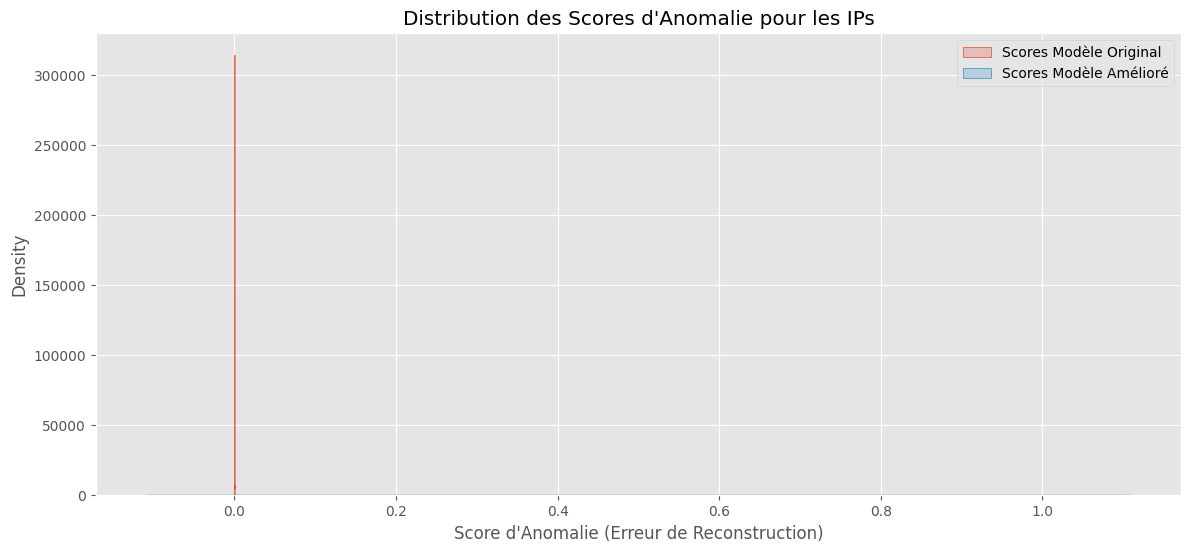

In [6]:
# ===================================================================
# Cellule 6 : Détection d'anomalies et analyse - CORRIGÉE
# ===================================================================

def get_anomaly_scores(model, data_split_obj, full_edge_index):
    """Calcule les erreurs de reconstruction pour tous les nœuds."""
    model.eval()
    with torch.no_grad():
        mu, _ = model.encoder(data_split_obj.x, data_split_obj.train_pos_edge_index)
        z = mu
        
        recon_error_matrix = 1 - model.decode_all(z)
        
        node_errors = torch.zeros(data_split_obj.num_nodes, device=device)
        
        row, col = full_edge_index
        
        edge_errors = recon_error_matrix[row, col]
        node_errors.scatter_add_(0, row, edge_errors)
        node_errors.scatter_add_(0, col, edge_errors)
        
        degrees = torch.bincount(row, minlength=data_split_obj.num_nodes) + torch.bincount(col, minlength=data_split_obj.num_nodes)
        node_errors /= degrees.clamp(min=1)
        
    return node_errors.cpu().numpy()

scores_orig = get_anomaly_scores(model_orig, data_split, original_edge_index)
scores_imp = get_anomaly_scores(model_improved, data_split, original_edge_index)

# Créer un DataFrame avec les scores et les caractéristiques
anomaly_df = node_features_df.copy()
anomaly_df['score_orig'] = scores_orig
anomaly_df['score_imp'] = scores_imp

# Identifier les nœuds de type IP
ip_anomaly_df = anomaly_df[anomaly_df['is_ip'] > 0.5].copy()

# MODIFICATION : Sélectionner plus de colonnes pour un affichage plus riche
cols_to_display = [
    'failure_rate', 'degree', 'total_attempts', 
    'num_countries', 'num_cities', # Nouvelles colonnes
    'score_orig', 'score_imp'
]

# Afficher les IPs les plus suspectes selon chaque modèle
print("\n--- Top 10 IPs suspectes (Modèle Original) ---")
display(ip_anomaly_df.sort_values('score_orig', ascending=False).head(10)[cols_to_display])

print("\n--- Top 10 IPs suspectes (Modèle Amélioré) ---")
display(ip_anomaly_df.sort_values('score_imp', ascending=False).head(10)[cols_to_display])

# Visualiser la distribution des scores d'anomalie
plt.figure(figsize=(14, 6))
sns.kdeplot(ip_anomaly_df['score_orig'], label='Scores Modèle Original', fill=True)
sns.kdeplot(ip_anomaly_df['score_imp'], label='Scores Modèle Amélioré', fill=True)
plt.title("Distribution des Scores d'Anomalie pour les IPs")
plt.xlabel("Score d'Anomalie (Erreur de Reconstruction)")
plt.legend()
plt.show()

Calcul de t-SNE pour 'Espace Latent t-SNE - Modèle Original'...


/opt/homebrew/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


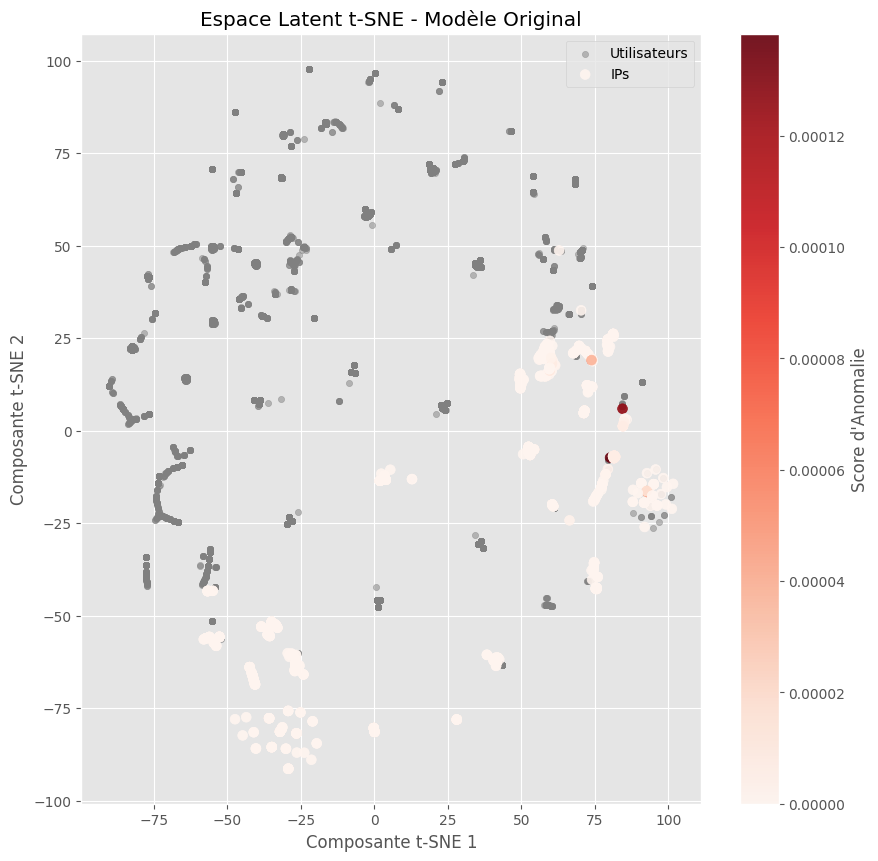

Calcul de t-SNE pour 'Espace Latent t-SNE - Modèle Amélioré'...


/opt/homebrew/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


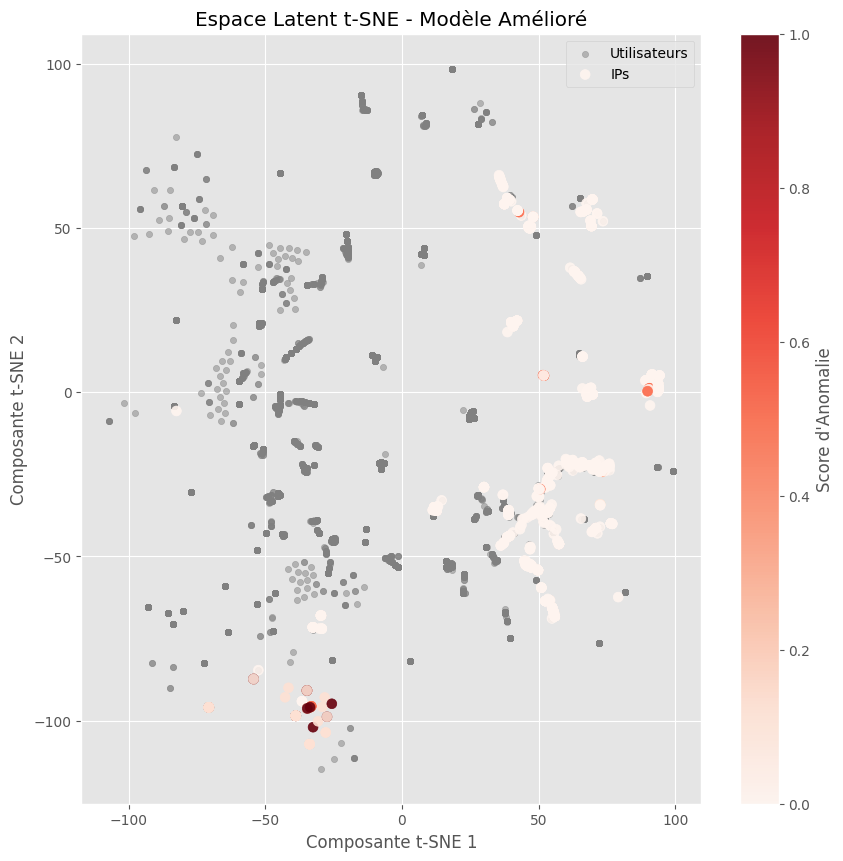

In [7]:
# ===================================================================
# Cellule 7 : Visualisation T-SNE des Espaces Latents - CORRIGÉE
# ===================================================================

# =================================================================================
# CORRECTION : La fonction doit accepter les mêmes arguments que get_anomaly_scores
# pour avoir accès aux bonnes listes d'arêtes.
# =================================================================================
def visualize_tsne(model, data_split_obj, full_edge_index, title):
    """Génère et affiche une visualisation t-SNE de l'espace latent."""
    model.eval()
    with torch.no_grad():
        # =================================================================================
        # CORRECTION :
        # 1. Utiliser model.encoder au lieu de model.encode.
        # 2. Récupérer mu comme la représentation latente (z).
        # 3. Utiliser les arêtes d'entraînement (train_pos_edge_index) pour l'encodage.
        # =================================================================================
        mu, _ = model.encoder(data_split_obj.x, data_split_obj.train_pos_edge_index)
        z = mu.cpu().numpy()
        
    # Appliquer t-SNE
    print(f"Calcul de t-SNE pour '{title}'...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    z_tsne = tsne.fit_transform(z)
    
    # Séparer IPs et Utilisateurs pour la visualisation
    is_ip = data_split_obj.x[:, 0].cpu().numpy() > 0.5
    
    plt.figure(figsize=(10, 10))
    # Afficher les utilisateurs en premier (en arrière-plan)
    plt.scatter(z_tsne[~is_ip, 0], z_tsne[~is_ip, 1], s=20, color='gray', alpha=0.5, label='Utilisateurs')
    
    # =================================================================================
    # CORRECTION : L'appel interne à get_anomaly_scores doit aussi utiliser
    # les bons arguments que nous avons maintenant à disposition.
    # =================================================================================
    ip_scores = get_anomaly_scores(model, data_split_obj, full_edge_index)[is_ip]
    plt.scatter(z_tsne[is_ip, 0], z_tsne[is_ip, 1], s=50, c=ip_scores, cmap='Reds', alpha=0.9, label='IPs')
    
    plt.title(title)
    plt.xlabel("Composante t-SNE 1")
    plt.ylabel("Composante t-SNE 2")
    plt.legend()
    cbar = plt.colorbar()
    cbar.set_label("Score d'Anomalie")
    plt.show()

# =================================================================================
# CORRECTION : On appelle la fonction de visualisation en passant les bons objets :
# `data_split` et la sauvegarde `original_edge_index`.
# =================================================================================
visualize_tsne(model_orig, data_split, original_edge_index, "Espace Latent t-SNE - Modèle Original")
visualize_tsne(model_improved, data_split, original_edge_index, "Espace Latent t-SNE - Modèle Amélioré")

In [8]:
# ===================================================================
# Cellule 8 : Sauvegarde des résultats et du meilleur modèle (v3)
# ===================================================================
# MODIFICATION : Nouveau dossier de résultats pour ne pas écraser les précédents
results_dir = "results_v3_geo"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# --- 1. Sauvegarder le meilleur modèle (basé sur le Test AP) ---
best_model = model_improved if test_ap_imp > test_ap_orig else model_orig
model_name = "improved_vgae" if test_ap_imp > test_ap_orig else "original_vgae"
model_path = os.path.join(results_dir, f"best_model_{model_name}.pt")
torch.save(best_model.state_dict(), model_path)
print(f"Meilleur modèle ('{model_name}') sauvegardé dans : {model_path}")

# --- 2. Sauvegarder le tableau de comparaison ---
comparison_path = os.path.join(results_dir, "model_comparison.csv")
results_df.to_csv(comparison_path, index=False)
print(f"Tableau de comparaison sauvegardé dans : {comparison_path}")

# --- 3. Sauvegarder la liste des IPs les plus suspectes ---
top_anomalies_path = os.path.join(results_dir, "top_anomalies.csv")
# MODIFICATION : On sauvegarde toutes les colonnes enrichies pour une analyse plus facile
ip_anomaly_df.sort_values('score_imp', ascending=False).head(100).to_csv(top_anomalies_path)
print(f"Top 100 des IPs suspectes sauvegardées dans : {top_anomalies_path}")

Meilleur modèle ('original_vgae') sauvegardé dans : results_v3_geo/best_model_original_vgae.pt
Tableau de comparaison sauvegardé dans : results_v3_geo/model_comparison.csv
Top 100 des IPs suspectes sauvegardées dans : results_v3_geo/top_anomalies.csv
